In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random
from scipy.stats import norm
from scipy.spatial import distance

In [15]:
def split(dataset, labelCol):
    
    training = []
    validation = []
    
    dataset = dataset[dataset[:,labelCol].argsort()]
    
    for i in range(len(dataset)):
        
        if i % 10 == 0:
            validation.append(dataset[i])
        
        else:
            training.append(dataset[i])
    
    return np.asarray(training), np.asarray(validation)

In [2]:
#2D Potential

x1 = 0.5
y1 = 0.5

x2 = -0.5
y2 = -0.5

W = 0.0001
sigma = 0.4

factor = 2

def gaussian(x, xo):
    
    g = math.exp(-1 * math.pow((x - xo), 2)/(2 * math.pow(sigma,2)))
    
    return g

def twoDpotential(x,y):
    
    V = W * (math.pow(x,6) + math.pow(y,6)) - factor * (gaussian(x, x1) * gaussian(y, y1)) \
        - factor * (gaussian(x, x2) * gaussian(y, y2)) 
    
    return V

def accX(x,y,vX):
    
    acc = W * (6 * math.pow(x,5)) \
            - factor * gaussian(y, y1) * gaussian(x, x1) * (-1 * 2 * (x - x1) / (2 * math.pow(sigma,2))) \
            - factor * gaussian(y, y2) * gaussian(x, x2) * (-1 * 2 * (x - x2) / (2 * math.pow(sigma,2)))
    
    return (-1 * acc)

def accY(x,y,vY):
    
    acc = W * (6 * math.pow(y,5)) \
            - factor * gaussian(y, y1) * gaussian(x, x1) * (-1 * 2 * (y - y1) / (2 * math.pow(sigma,2))) \
            - factor * gaussian(y, y2) * gaussian(x, x2) * (-1 * 2 * (y - y2) / (2 * math.pow(sigma,2)))
    
    return (-1 * acc)

def run_2D_md(dt, number_of_steps, temp, coord):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length (s)
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at 
        initialisation (K)
    x: ndarray of floats
        The initial positions of the particles in a 
        single dimension (Å)
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles 
        throughout the simulation (Å)
    """
#    positions = np.zeros((number_of_steps, len(x)))
    positionsX = []
    positionsY = []
    positionsX.append(coord[0])
    positionsY.append(coord[1])
    
    x = coord[0]
    y = coord[1]
    
    vX = np.random.uniform(-1 * temp, temp)
    vY = np.random.uniform(-1 * temp, temp)
    aX = accX(x,y,vX)
    aY = accY(x,y,vY)

    for i in range(number_of_steps):
        x = update_pos(x, vX, aX, dt)
        y = update_pos(y, vY, aY, dt)
        a1X = accX(x,y,vX)
        a1Y = accY(x,y,vY)
        vX = update_velo(vX, aX, a1X, dt)
        vY = update_velo(vY, aY, a1Y, dt)
        aX = np.array(a1X)
        aY = np.array(a1Y)
        positionsX.append(x)
        positionsY.append(y)
#        print(x,y,vX,vY,aX,aY,i)
#        positions[i, :] = x
    return positionsX, positionsY

In [17]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new

#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=5, **kwargs ):
    x = initial_position[0]
    y = initial_position[1]
    vx = initial_velocity[0]
    vy = initial_velocity[1]

    t = 0
    step_number = 0
    
    positions = []
    velocities = []
    
    total_energies = []
    save_times = []
    
    while(t<max_time):
        
        # B
        potential_energy = potential(x,y,**kwargs)
        forceX = accX(x,y,vx)
        forceY = accY(x,y,vy)
        
        vx = velocity_update(vx,forceX,dt)
        vy = velocity_update(vy,forceY,dt)
        
        #A
        x = position_update(x,vx,dt)
        y = position_update(y,vy,dt)

        #O
        vx = random_velocity_update(vx,gamma,kBT,dt)
        vy = random_velocity_update(vy,gamma,kBT,dt)

        #A
        x = position_update(x,vx,dt)
        y = position_update(y,vy,dt)
        
        # B
        potential_energy = twoDpotential(x,y,**kwargs)
        forceX = accX(x,y,vx)
        forceX = accY(x,y,vy)
        
        vx = velocity_update(vx,forceX,dt)
        vy = velocity_update(vy,forceY,dt)

        if step_number%save_frequency == 0 and step_number>0:
            ke = .5*(vx*vx + vy*vy)
            pe = potential_energy

            positions.append([x,y])
            velocities.append([vx,vy])
            total_energies.append([ke,pe,ke+pe])
            save_times.append(t)
        
        if t % (500) < 0.01:
            print("Currently at t = " + str(t))
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

Initial Coordinates = 0, 0
Initial Velocities = 0.09895251930186608, 0.14031829906580132
Initial Kinetic Energy = 0.01474041306445292
Initial Potential energy = -0.8384455486043915
Initial Total energy = -0.8237051355399385
Currently at t = 0
Currently at t = 500.00999999969025
Currently at t = 1000.0099999992356
Currently at t = 1500.0099999987808
Currently at t = 2000.009999998326
Currently at t = 2500.0000000081486
Currently at t = 3000.0000000190626
Currently at t = 3500.0000000299765
Currently at t = 4000.0000000408904
Currently at t = 4500.000000051804
Currently at t = 5000.000000062718
Currently at t = 5500.000000073632
Currently at t = 6000.000000084546
Currently at t = 6500.00000009546
Currently at t = 7000.000000106374
Currently at t = 7500.0000001172875
Currently at t = 8000.0000001282015
Currently at t = 8500.000000139114
Currently at t = 9000.000000150028
Currently at t = 9500.000000160942


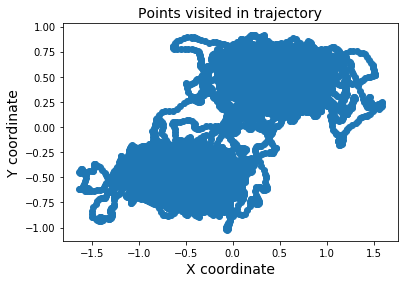

In [41]:
my_max_time = 10000

x = 0
y = 0
vx = np.random.normal(0,0.3)
vy = np.random.normal(0,0.3)

initial_position = [x,y]
initial_velocity = [vx,vy]

my_gamma = 5
my_kBT=(1/9.5)
my_dt=0.01

KE = 0.5 * (vx * vx + vy * vy)
PE = twoDpotential(x,y)

print("Initial Coordinates = " + str(x) + ", " + str(y))
print("Initial Velocities = " + str(vx) + ", " + str(vy))
print("Initial Kinetic Energy = " + str(KE))

print("Initial Potential energy = " + str(PE))

print("Initial Total energy = " + str(PE + KE))


times, positions, velocities, total_energies = baoab(twoDpotential, \
                                                    my_max_time, my_dt, my_gamma, my_kBT, \
                                                    initial_position, initial_velocity,\
                                                    )



times = np.asarray(times)
positions = np.asarray(positions)
velocities = np.asarray(velocities)
total_energies = np.asarray(total_energies)

plt.title('Points visited in trajectory', size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(positions[:,0], positions[:,1])
plt.savefig('toyModel/2DlangevinNormalT/trajectory.png')

In [42]:
# positions = np.load('toyModel/2DlangevinNormalT/positions.npy')
# velocities = np.load('toyModel/2DlangevinNormalT/velocities.npy')

In [43]:
print("Average Kinetic Energy = " + str(total_energies[:,0].mean()))
print("kBT = ", my_kBT)
print("Average Potential Energy = " + str(total_energies[:,1].mean()))
print("Average Total Energy = " + str(total_energies[:,2].mean()))

Average Kinetic Energy = 0.10859948859240205
kBT =  0.10526315789473684
Average Potential Energy = -1.7934952915138014
Average Total Energy = -1.684895802921399


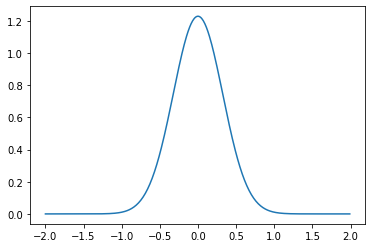

In [44]:
import scipy
from scipy.stats import maxwell
import matplotlib.pyplot as plt
import math

k = scipy.constants.k

def maxwell(v,T=1/(k*9.5),m=1):
    
    k = scipy.constants.k
    pi = scipy.constants.pi
    
    f = math.sqrt(2/pi) * math.pow(m/(k*T),3/2) * np.square(v) *  np.exp((-1*m*np.square(v))/(2*k*T))
    
    return f


def maxwellVelocity(c,T=1/(k*9.5),m=1):
    
    k = scipy.constants.k
    pi = scipy.constants.pi
        
    f = math.sqrt((m/(2*pi*my_kBT))) * np.exp((-1*m*np.square(c))/(2*my_kBT))
    return f

x = np.arange(-2,2,0.01)
y = maxwellVelocity(x,my_kBT/k,1)    
    
plt.plot(x,y)

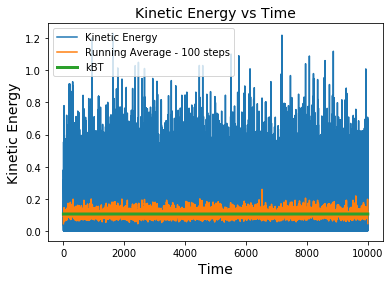

In [45]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

window_size = 100
ke_av = movingaverage(total_energies[:,0], window_size)

x = np.arange(len(total_energies[:,0]))/20
plt.title('Kinetic Energy vs Time', size=14)
plt.plot(x,total_energies[:,0], label = 'Kinetic Energy')
plt.plot(x,ke_av, label='Running Average - ' + str(window_size) + ' steps')
plt.plot(x,[my_kBT]*len(total_energies[:,0]), linewidth=3.0, label='kBT')
plt.legend(loc='upper left')
plt.xlabel('Time', size=14)
plt.ylabel('Kinetic Energy', size=14)
plt.savefig('toyModel/2DlangevinNormalT/KE.png')

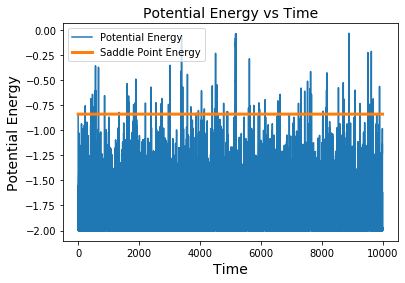

In [46]:
x = np.arange(len(total_energies[:,0]))/20
plt.title('Potential Energy vs Time', size=14)
plt.plot(x,total_energies[:,1], label = 'Potential Energy')
plt.plot(x,[twoDpotential(0,0)]*len(total_energies[:,0]), linewidth=3.0, label='Saddle Point Energy')
plt.legend(loc='upper left')
plt.xlabel('Time', size=14)
plt.ylabel('Potential Energy', size=14)
plt.savefig('toyModel/2DlangevinNormalT/PE.png')


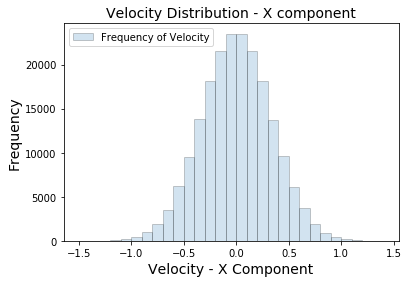

In [47]:
plt.title('Velocity Distribution - X component', size=14)
plt.xlabel('Velocity - X Component', size=14)
plt.ylabel('Frequency', size=14)
bins_list = np.arange(-1.5,1.5,0.1)
plt.hist(velocities[:,0], edgecolor='k', alpha=0.2, bins=bins_list,label='Frequency of Velocity')
plt.legend(loc='upper left')
plt.savefig('toyModel/2DlangevinNormalT/velocityX.png')

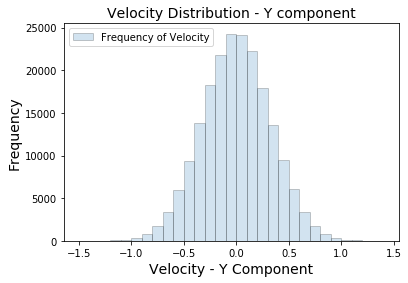

In [48]:
plt.title('Velocity Distribution - Y component', size=14)
plt.xlabel('Velocity - Y Component', size=14)
plt.ylabel('Frequency', size=14)
bins_list = np.arange(-1.5,1.5,0.1)
plt.hist(velocities[:,1], edgecolor='k', alpha=0.2, bins=bins_list,label='Frequency of Velocity')
plt.legend(loc='upper left')
plt.savefig('toyModel/2DlangevinNormalT/velocityY.png')

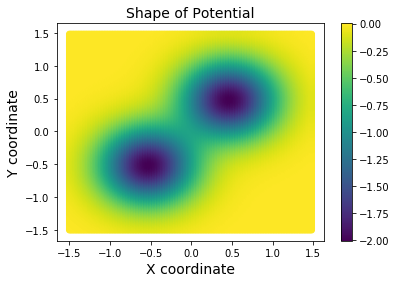

In [49]:
a = np.arange(x2-1,x1+1,0.02)
b = np.arange(y2-1,y1+1,0.02)

potential = []

for x in a:
    for y in b:
        
        potential.append([x,y,twoDpotential(x,y)])

potential = np.asarray(potential)

plt.title('Shape of Potential', size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(potential[:,0],potential[:,1],c=potential[:,2])
# plt.tricontour(potential[:,0],potential[:,1],potential[:,2],500)
plt.colorbar()
plt.savefig('toyModel/2DlangevinNormalT/potential.png')

In [50]:
# positionsX = positions[:,0]
# positionsY = positions[:,1]
# velocitiesX = velocities[:,0]
# velocitiesY = velocities[:,1]

# min1 = twoDpotential(x1,y1)
# min2 = twoDpotential(x2,y2)

# width = my_kBT

# data = np.vstack((positionsX,positionsY,velocitiesX,velocitiesY)).T

# dataset = []
# nextState = [-1, -1]

# nTransitions = -1
# prevState = -1

# tTransitions = []

# cutoff = 100

# cutoffPoint = []

# for i in range(len(data)):
    
#     if i % 9999 == 0:
#         print("Finished step: " + str(i+1) + " of " + str(len(data)))
    
#     x = data[i][0]
#     y = data[i][1]
#     velX = data[i][2]
#     velY = data[i][3]
    
#     if i < nextState[0]:
#         dataset.append([x, y, velX, velY, nextState[1]])
#         continue
    
#     currPotential = twoDpotential(x,y)

#     dist1 = np.sqrt(math.pow(x-x1,2) + math.pow(y-y1,2))
#     dist2 = np.sqrt(math.pow(x-x2,2) + math.pow(y-y2,2))
# #     if np.sqrt(math.pow(x-x1,2) + math.pow(y-y1,2)) < width:
#     if currPotential - min1 < width and dist1 < dist2:
#         dataset.append([x, y, velX, velY, 1])
#         continue
    
# #     if np.sqrt(math.pow(x-x2,2) + math.pow(y-y2,2)) < width:
#     if currPotential - min2 < width and dist2 < dist1:
#         dataset.append([x, y, velX, velY, 2])
#         continue
            
#     for j in range(i, len(data)):
        
#         if j - i > cutoff:
#             dataset.append([x,y, velX, velY, 3])
#             cutoffFlag = 1
#             continue
            
#         xj = data[j][0]
#         yj = data[j][1]
        
#         if np.sqrt(math.pow(xj - x1,2) + math.pow(yj - y1,2)) < width:
#             dataset.append([x, y, velX, velY, 1])
#             nextState = [j,1]
            
#             if nTransitions == -1:
#                 prevState = 1
#                 nTransitions += 1

#             else:
#                 if prevState != 1:
#                     nTransitions += 1
#                     prevState = 1
#                     tTransitions.append(i)
#             break

#         if np.sqrt(math.pow(xj - x2,2) + math.pow(yj - y2,2)) < width:
            
#             dataset.append([x, y, velX, velY, 1])
#             nextState = [j,2]
            
#             if nTransitions == -1:
#                 prevState = 2
#                 nTransitions += 1
                
#             else:
#                 if prevState != 2:
#                     nTransitions += 1
#                     prevState = 2
#                     tTransitions.append(i)
#             break

# dataset = np.asarray(dataset)
# unique, counts = np.unique(dataset[:,4], return_counts = True)
# print(unique, counts)

In [51]:
positionsX = positions[:,0]
positionsY = positions[:,1]
velocitiesX = velocities[:,0]
velocitiesY = velocities[:,1]

min1 = twoDpotential(x1,y1)
min2 = twoDpotential(x2,y2)

width = my_kBT

data = np.vstack((positionsX,positionsY,velocitiesX,velocitiesY)).T

dataset = []
nextState = [-1, -1]

nTransitions = -1
prevState = -1

tTransitions = []

cutoff = 10000000000

inBasin= [-1, -1]

indet = [-1, -1]

for i in range(len(data)):
    
    if i % 9999 == 0:
        print("Finished step: " + str(i+1) + " of " + str(len(data)))
    
    x = data[i][0]
    y = data[i][1]
    velX = data[i][2]
    velY = data[i][3]
    
    if i < nextState[0]:
        dataset.append([x, y, velX, velY, nextState[1]])
        continue
    
    if indet[0] == 1:
        
        xj = data[indet[1] + 1][0]
        yj = data[indet[1] + 1][1]
        
        currPotential = twoDpotential(xj,yj)
        
        dist1 = distance.euclidean([xj,yj],[x1,y1])
        dist2 = distance.euclidean([xj,yj],[x2,y2])

        
        if currPotential - min1 < width and dist1 < dist2:
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,1]
            indet = [-1, -1]
            
            if nTransitions == -1:
                prevState = 1
                nTransitions += 1

            else:
                if prevState != 1:
                    nTransitions += 1
                    prevState = 1
                    tTransitions.append(i)
            
            continue

        elif currPotential - min2 < width and dist2 < dist1:
            dataset.append([x, y, velX, velY, 2])
            nextState = [j,2]
            indet = [-1, -1]
            
            if nTransitions == -1:
                prevState = 2
                nTransitions += 1
                
            else:
                if prevState != 2:
                    nTransitions += 1
                    prevState = 2
                    tTransitions.append(i)
            
            continue
        
        else:
            dataset.append([x, y, velX, velY, 3])
            indet = [1,indet[1]+1]
            continue

    currPotential = twoDpotential(x,y)

    dist1 = distance.euclidean([x,y],[x1,y1])
    dist2 = distance.euclidean([x,y],[x2,y2])
    
    if 0 <= currPotential - min1 <= width and dist1 < dist2:
        dataset.append([x, y, velX, velY, 1])
        inBasin = i
        continue
    
    if 0 <= currPotential - min2 <= width and dist2 < dist1:
        dataset.append([x, y, velX, velY, 2])
        inBasin = i
        continue
    
    for j in range(i, len(data)):
        
        if j - i > cutoff:
            dataset.append([x,y, velX, velY, 3])
            indet = [1, j]
            break
            
        xj = data[j][0]
        yj = data[j][1]
        
        dist1 = distance.euclidean([xj,yj],[x1,y1])
        dist2 = distance.euclidean([xj,yj],[x2,y2])
        
        currPotential = twoDpotential(xj,yj)
        
        if 0 <= currPotential - min1 <= width and dist1 < dist2:
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,1]
            indet = [-1, -1]
            
            if nTransitions == -1:
                prevState = 1
                nTransitions += 1

            else:
                if prevState != 1:
                    nTransitions += 1
                    prevState = 1
                    tTransitions.append(np.asarray([inBasin,j]))
            break

        if 0 <= currPotential - min2 <= width and dist2 < dist1:
            
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,2]
            indet = [-1,-1]
            
            if nTransitions == -1:
                prevState = 2
                nTransitions += 1
                
            else:
                if prevState != 2:
                    nTransitions += 1
                    prevState = 2
                    tTransitions.append(np.asarray([inBasin,j]))
            break

dataset = np.asarray(dataset)
unique, counts = np.unique(dataset[:,4], return_counts = True)
print(unique, counts)

Finished step: 1 of 199999
Finished step: 10000 of 199999
Finished step: 19999 of 199999
Finished step: 29998 of 199999
Finished step: 39997 of 199999
Finished step: 49996 of 199999
Finished step: 59995 of 199999
Finished step: 69994 of 199999
Finished step: 79993 of 199999
Finished step: 89992 of 199999
Finished step: 99991 of 199999
Finished step: 109990 of 199999
Finished step: 119989 of 199999
Finished step: 129988 of 199999
Finished step: 139987 of 199999
Finished step: 149986 of 199999
Finished step: 159985 of 199999
Finished step: 169984 of 199999
Finished step: 179983 of 199999
Finished step: 189982 of 199999
Finished step: 199981 of 199999
[1. 2.] [125277  74722]


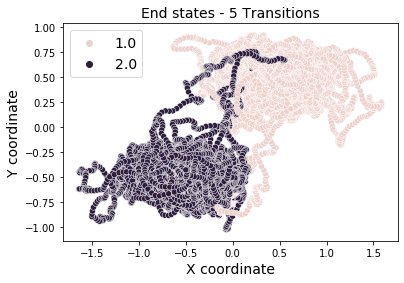

In [52]:
import seaborn as sns

text = 'nTransitions = ' + str(nTransitions)
df = pd.DataFrame(dataset, columns = ['X Coordinate','Y Coordinate','velX','velY','endState'])
a = sns.scatterplot(data=df, x='X Coordinate', y='Y Coordinate', hue='endState')
a.legend(fontsize=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
a.set_title('End states - ' + str(nTransitions) + ' Transitions', size=14)
a.figure.savefig('toyModel/2DlangevinNormalT/endState.png')

In [55]:
import torch 
import torch.nn.functional as F
from torch import optim
import torch.nn as nn


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 8)
        self.hidden2 = nn.Linear(8,4)
        self.activation = nn.ReLU()
        self.output = nn.Linear(4, 2)

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.output(x)
        return x

In [56]:
dataset = np.asarray(dataset)

labelCol = len(dataset[0]) - 1
training, validation = split(dataset, labelCol)

trainInputs = training[:,:labelCol]
trainLabels = training[:,labelCol]
validInputs = validation[:,:labelCol]
validLabels = validation[:,labelCol]

trainInputs = torch.Tensor(trainInputs)
trainLabels = torch.Tensor(trainLabels).type(torch.LongTensor) - 1

In [57]:
model = Model()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
nEpochs = 1000
losses = np.zeros(nEpochs)

for epoch in range(0, nEpochs): ## run the model for 100 epochs
    
    model.train()
    
    optimizer.zero_grad()
    
    output = model(trainInputs)
    loss = loss_function(output, trainLabels)
    
    loss.backward()
    
    optimizer.step()
    
    losses[epoch] = np.mean(loss.item())
    
    if epoch % 100 == 0:
        print ("Epoch:", epoch, "Training Loss: ", np.mean(loss.item()), ((output.argmax(dim=1) == trainLabels).sum()/len(trainLabels)).item())
    
    

/home/preetham/.local/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch: 0 Training Loss:  0.788193941116333 0.373613178730011
Epoch: 100 Training Loss:  0.6605973243713379 0.8971161246299744
Epoch: 200 Training Loss:  0.43838274478912354 0.9841943383216858
Epoch: 300 Training Loss:  0.17877700924873352 0.9864888191223145
Epoch: 400 Training Loss:  0.08600515872240067 0.9868665933609009
Epoch: 500 Training Loss:  0.06639087200164795 0.9868943691253662
Epoch: 600 Training Loss:  0.06136966496706009 0.9869221448898315
Epoch: 700 Training Loss:  0.05967467650771141 0.9869276881217957
Epoch: 800 Training Loss:  0.05886705219745636 0.9869276881217957
Epoch: 900 Training Loss:  0.05838949978351593 0.9869499206542969


In [85]:
output = model(torch.Tensor(validInputs))
validLabels = torch.Tensor(validLabels).type(torch.LongTensor) - 1
loss = loss_function(output, validLabels)
print ("Validation Loss: ", np.mean(loss.item()), ((output.argmax(dim=1) == validLabels).sum()/len(validLabels)).item())


Validation Loss:  0.058715641498565674 0.9868500232696533


In [ ]:
###### plt.title('Learning Curve', size=14)
plt.xlabel('Epoch', size=14)
plt.ylabel('Cross-Entropy Loss', size=14)
plt.plot(losses, label='BCE Loss')
plt.legend()
plt.savefig('toyModel/2DlangevinNormalT/lossCurve.png')

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

dataset = np.asarray(dataset)

labelCol = len(dataset[0]) - 1
training, validation = split(dataset, labelCol)

trainInputs = training[:,:labelCol]
trainLabels = training[:,labelCol]
validInputs = validation[:,:labelCol]
validLabels = validation[:,labelCol]

scaler = preprocessing.StandardScaler().fit(trainInputs)

clf = MLPClassifier(hidden_layer_sizes=[8,4], alpha=0.001,\
                    max_iter = 2000, solver='adam')

clf.fit(scaler.transform(trainInputs), trainLabels)

print("Training accuracy =  ", clf.score(scaler.transform(trainInputs), trainLabels))
print("Validation accuracy = ", clf.score(scaler.transform(validInputs), validLabels))

In [17]:
# space=[
#     Categorical(['tanh','relu'],name='activation'),
#     Integer(2,16,name='hiddenLayer1'),
#     Integer(2,16,name='hiddenLayer2'),
#     Integer(2,16,name='hiddenLayer3'),
#     Real(1e-3,1e-1,name='learning_rate_init')
#     ]


In [18]:
# from sklearn.neural_network import MLPClassifier
# from sklearn import preprocessing
# from skopt.space import Real, Integer, Categorical 
# from skopt.utils import use_named_args
# from skopt import gp_minimize

# space=[
#     Categorical(['tanh','relu'],name='activation'),
#     Integer(2,16,name='hiddenLayer1'),
#     Integer(2,16,name='hiddenLayer2'),
#     Integer(2,16,name='hiddenLayer3'),
#     Real(1e-3,1e-1,name='learning_rate_init')
#     ]

# dataset = np.asarray(dataset)

# labelCol = len(dataset[0]) - 1
# training, validation = split(dataset, labelCol)

# trainInputs = training[:,:labelCol]
# trainLabels = training[:,labelCol]
# validInputs = validation[:,:labelCol]
# validLabels = validation[:,labelCol]

# # scaler = preprocessing.StandardScaler().fit(trainInputs)

# clf = MLPClassifier(max_iter = 1000, solver='adam', random_state=31)


# @use_named_args(space)

# def objective(**params):
    
    
#     params['hidden_layer_sizes']=tuple([params['hiddenLayer1'], \
#                                        params['hiddenLayer2'], \
#                                        params['hiddenLayer3'], \
#                                        ])
    
#     print(params)

#     # the parameters are deleted to avoid an error from the MLPRegressor
#     params.pop('hiddenLayer1')
#     params.pop('hiddenLayer2')
#     params.pop('hiddenLayer3')

#     clf.set_params(**params)
    
#     clf.fit(trainInputs, trainLabels)
    
#     acc = clf.score(validInputs, validLabels)
#     print("Accuracy = ", acc)

#     return (1 - acc)


# clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# # print(scaler.transform(trainInputs).mean())
# print("Optimal params = " + str(clf_gp.x))
# print("Validation Accuracy = ", 1 - clf_gp.fun)

In [19]:
# committor = []

# trials = 250

# xarray = np.repeat(dataset[:,0], repeats=trials, axis=0)
# yarray = np.repeat(dataset[:,1], repeats=trials, axis=0)

# meanX,stdX=norm.fit(velocities[:,0])
# meanY,stdY=norm.fit(velocities[:,1])

# velX = np.random.normal(meanY, stdY, len(xarray))
# velY = np.random.normal(meanY, stdY, len(yarray))

# print("Started predictions")

# toPred = np.vstack((xarray,yarray,velX,velY)).T
# toPred = scaler.transform(toPred)
# preds = clf.predict(toPred)    

# for i in range(0, len(dataset[:,0])):
    
#     predictions = preds[i*trials:(i+1)*trials]
#     unique, count = np.unique(predictions, return_counts=True)
#     if len(unique) == 1:        
#         if unique == 0:
#             counts = [count[0], 0]

#         else:
#             counts = [0, count[0]]
#     else:

#         counts = count

#     counts = np.asarray(counts)/trials
#     committor.append([dataset[i][0],dataset[i][1],counts[1]])

#     if i % 9999 == 0:
#         print("Finished step " + str(i+1) + " of " + str(len(dataset)))


# committor = np.asarray(committor)

# print("Finished predictions")

# # plt.title('Learned Committor Probability', size = 14)
# # plt.xlabel('Position x', size=14)
# # plt.ylabel('Learned Committor Probability', size=12)


# #plt.tricontour(committor[:,0], committor[:,1], committor[:2])
# # plt.savefig('toyModel/learnedComm.png')    

In [78]:
trials = 500
batch_size = 10000

meanX,stdX=norm.fit(velocities[:,0])
meanY,stdY=norm.fit(velocities[:,1])

print("Started predictions")

committor = np.asarray([0,0])

for i in range(0,len(dataset[:,0])+1,batch_size):
    
    committorTemp = np.zeros((batch_size,2))

    xarray = np.repeat(dataset[i:i+batch_size,0], repeats=trials, axis=0)
    yarray = np.repeat(dataset[i:i+batch_size,1], repeats=trials, axis=0)

    velX = np.random.normal(0, stdX, len(xarray))
    velY = np.random.normal(0, stdY, len(yarray))
    
#     factorKE = (np.square(velX) + np.square(velY))/2
    
#     velX = np.multiply(velX, factorKE)
#     velY = np.multiply(velY, factorKE)

    toPred = np.vstack((xarray,yarray,velX,velY)).T
#     toPred = scaler.transform(toPred)
    preds = model(torch.Tensor(toPred))
    preds = preds.argmax(dim=1)
    preds = np.asarray(preds.detach().numpy())
    for j in range(0, batch_size):
        
        if i+j >= len(dataset):
            committorTemp = committorTemp[:j]
            break
        predictions = preds[j*trials:(j+1)*trials]
        unique, count = np.unique(predictions, return_counts=True)
        counts = [0,0]
        if len(unique) == 1:
            counts[int(unique[0]) - 1] = count[0]
        elif len(unique) == 2:
            counts[int(unique[0]) - 1] = count[0]
            counts[int(unique[1]) - 1] = count[1]
        
        if (counts[0] + counts[1]) != 0:
            counts = np.asarray(counts)/(counts[0]+counts[1])
            
        committorTemp[j] = [counts[0],counts[1]]
        
        
        if int(i+j+1) % 10000 == 0:
            print("Finished step " + str(i+j+1) + " of " + str(len(dataset)))
    
    committor = np.vstack((committor,committorTemp))
    print(committor.shape, committor[-1,:])
    
committor = committor[1:]

Started predictions
Finished step 10000 of 199999
(10001, 2) [0. 1.]
Finished step 20000 of 199999
(20001, 2) [0. 1.]
Finished step 30000 of 199999
(30001, 2) [0. 1.]
Finished step 40000 of 199999
(40001, 2) [0. 1.]
Finished step 50000 of 199999
(50001, 2) [1. 0.]
Finished step 60000 of 199999
(60001, 2) [1. 0.]
Finished step 70000 of 199999
(70001, 2) [1. 0.]
Finished step 80000 of 199999
(80001, 2) [0. 1.]
Finished step 90000 of 199999
(90001, 2) [0. 1.]
Finished step 100000 of 199999
(100001, 2) [0. 1.]
Finished step 110000 of 199999
(110001, 2) [0. 1.]
Finished step 120000 of 199999
(120001, 2) [0. 1.]
Finished step 130000 of 199999
(130001, 2) [0. 1.]
Finished step 140000 of 199999
(140001, 2) [0. 1.]
Finished step 150000 of 199999
(150001, 2) [1. 0.]
Finished step 160000 of 199999
(160001, 2) [1. 0.]
Finished step 170000 of 199999
(170001, 2) [1. 0.]
Finished step 180000 of 199999
(180001, 2) [1. 0.]
Finished step 190000 of 199999
(190001, 2) [1. 0.]
(200000, 2) [1. 0.]


In [77]:
trials = 500
batch_size = 10000

meanX,stdX=norm.fit(velocities[:,0])
meanY,stdY=norm.fit(velocities[:,1])

print("Started predictions")

committor = np.asarray([0,0,0])

for i in range(0,len(dataset[:,0])+1,batch_size):
    
    committorTemp = np.zeros((batch_size,3))

    xarray = np.repeat(dataset[i:i+batch_size,0], repeats=trials, axis=0)
    yarray = np.repeat(dataset[i:i+batch_size,1], repeats=trials, axis=0)

    velX = np.random.normal(0, stdX, len(xarray))
    velY = np.random.normal(0, stdY, len(yarray))
    
#     factorKE = (np.square(velX) + np.square(velY))/2
    
#     velX = np.multiply(velX, factorKE)
#     velY = np.multiply(velY, factorKE)

    toPred = np.vstack((xarray,yarray,velX,velY)).T
    toPred = scaler.transform(toPred)
    preds = clf.predict(toPred)    

    for j in range(0, batch_size):
        
        if i+j >= len(dataset):
            committorTemp = committorTemp[:j]
            break
        predictions = preds[j*trials:(j+1)*trials]
        unique, count = np.unique(predictions, return_counts=True)
        counts = [0,0,0]
        if len(unique) == 1:
            counts[int(unique[0]) - 1] = count[0]
        elif len(unique) == 2:
            counts[int(unique[0]) - 1] = count[0]
            counts[int(unique[1]) - 1] = count[1]
        
        if (counts[0] + counts[1]) != 0:
            counts = np.asarray(counts)/(counts[0]+counts[1])
            
        committorTemp[j] = [counts[0],counts[1],counts[2]]
        
        
        if int(i+j+1) % 10000 == 0:
            print("Finished step " + str(i+j+1) + " of " + str(len(dataset)))
    
    committor = np.vstack((committor,committorTemp))
    print(committor.shape)
    
committor = committor[1:]

Started predictions
Finished step 10000 of 399991
(10001, 3)
Finished step 20000 of 399991
(20001, 3)
Finished step 30000 of 399991
(30001, 3)
Finished step 40000 of 399991
(40001, 3)
Finished step 50000 of 399991
(50001, 3)
Finished step 60000 of 399991
(60001, 3)
Finished step 70000 of 399991
(70001, 3)
Finished step 80000 of 399991
(80001, 3)
Finished step 90000 of 399991
(90001, 3)
Finished step 100000 of 399991
(100001, 3)
Finished step 110000 of 399991
(110001, 3)
Finished step 120000 of 399991
(120001, 3)
Finished step 130000 of 399991
(130001, 3)
Finished step 140000 of 399991
(140001, 3)
Finished step 150000 of 399991
(150001, 3)
Finished step 160000 of 399991
(160001, 3)
Finished step 170000 of 399991
(170001, 3)
Finished step 180000 of 399991
(180001, 3)
Finished step 190000 of 399991
(190001, 3)
Finished step 200000 of 399991
(200001, 3)
Finished step 210000 of 399991
(210001, 3)
Finished step 220000 of 399991
(220001, 3)
Finished step 230000 of 399991
(230001, 3)
Finished 

In [70]:
print(committor)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


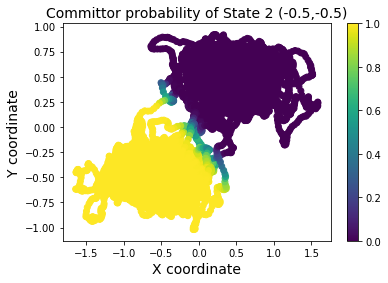

In [98]:
import matplotlib.tri as tri

x = dataset[:,0]
y = dataset[:,1]
z = committor[:,0]

plt.title("Committor probability of State 2 (-0.5,-0.5)", size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(x,y,c=z)
plt.colorbar()
plt.savefig("toyModel/2DlangevinNormalT/MLP_CommProb.png")

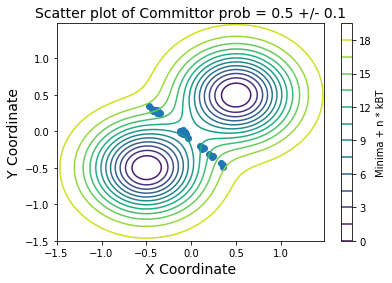

In [97]:
deviation = 0.1

transitionPtsIndices = np.where(np.logical_and(committor[:,1] > (0.5 - deviation), \
                         committor[:,1] < (0.5 + deviation)))

transitionPts = dataset[transitionPtsIndices]

minPotential = potential[:,2].min()

transitionPts = np.asarray(transitionPts)
plt.title("Scatter plot of Committor prob = 0.5 +/- " + str(deviation), size=14)
plt.xlabel("X Coordinate", size=14)
plt.ylabel("Y Coordinate", size=14)
plt.scatter(transitionPts[:,0],transitionPts[:,1])
plt.tricontour(potential[:,0],potential[:,1],(potential[:,2] - minPotential)/my_kBT, 15)
plt.colorbar(label='Minima + n * kBT')
plt.savefig("toyModel/2DlangevinNormalT/MLP_TS_p1.png")

-0.00011222801584818557 0.33480368093582885


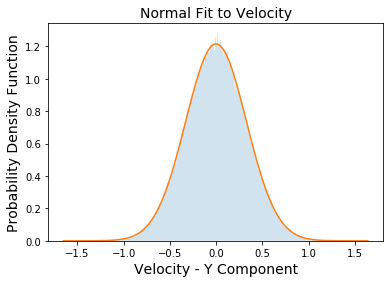

In [50]:
meanX,stdX=norm.fit(velocities[:,0])
meanY,stdY=norm.fit(velocities[:,1])

print(meanX, stdX)
bins_list = np.arange(-1.5,1.5,0.01)
plt.hist(velocities[:,1], density=1, bins=bins_list, histtype='stepfilled', alpha=0.2)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, meanY, stdY)

plt.title("Normal Fit to Velocity", size=14)
plt.xlabel("Velocity - Y Component", size=14)
plt.ylabel("Probability Density Function", size=14)
plt.plot(x, y)
plt.savefig("toyModel/2DlangevinNormalT/gaussianFitY.png")
plt.show()

In [12]:
my_kBT = 1/9.5

midX = (x1+x2)/2
midY = (y1+y2)/2

print((twoDpotential(x1,y1) - twoDpotential(midX,midY))/my_kBT)
print((twoDpotential(x2,y2) - twoDpotential(midX,midY))/my_kBT)

-11.071416229346609
-11.071416229346609


-0.00011222801584818557 0.33480368093582885


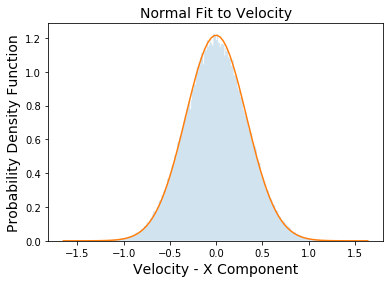

In [51]:
meanX,stdX=norm.fit(velocities[:,0])
meanY,stdY=norm.fit(velocities[:,1])

print(meanX, stdX)
bins_list = np.arange(-1.5,1.5,0.01)
plt.hist(velocities[:,0], density=1, bins=bins_list, histtype='stepfilled', alpha=0.2)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, meanY, stdY)

plt.title("Normal Fit to Velocity", size=14)
plt.xlabel("Velocity - X Component", size=14)
plt.ylabel("Probability Density Function", size=14)
plt.plot(x, y)
plt.savefig("toyModel/2DlangevinNormalT/gaussianFitX.png")
plt.show()

In [55]:
print(np.sqrt(1/9.5))

0.3244428422615251


In [7]:
print(twoDpotential(0,0) - twoDpotential(x1,y1))
print(twoDpotential(0,0) - twoDpotential(x2,y2))

1.165412234668064
1.165412234668064
